In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [2]:
df = pd.read_csv("../data/fromAPI/cleaned_hourly_all3.csv")

In [3]:
date_format = "%Y-%m-%d %H:%M:%S"
df["arrival_plan"] = pd.to_datetime(df["arrival_plan"], format=date_format)
df["departure_plan"] = pd.to_datetime(df["departure_plan"], format=date_format)
df["arrival_change"] = pd.to_datetime(df["arrival_change"], format=date_format)
df["departure_change"] = pd.to_datetime(df["departure_change"], format=date_format)
df["departure_plan_hour"] = df["departure_plan"].dt.hour
df["departure_plan_date"] = df["departure_plan"].dt.date

df = df.dropna(subset=["departure_plan"])
df.loc[:, "departure_plan_hour"] = df["departure_plan"].dt.hour
df.loc[:, "departure_plan_datetime"] = (
    df["departure_plan_date"].astype(str) + ' ' +
    df["departure_plan_hour"].astype(str) + ':00:00'
)
df.loc[:, "departure_plan_datetime"] = pd.to_datetime(df["departure_plan_datetime"], format=date_format)

df.head()


,ID,line,path,eva_nr,category,station,state,city,zip,long,...,departure_change,arrival_delay_m,departure_delay_m,info,attention: datapoints 240711_04 - 240711_06 are simulated because of measurement issues,arrival_delay_check,departure_delay_check,departure_plan_hour,departure_plan_date,departure_plan_datetime
0,1573967790757085557-2407072312-14,20,Stolberg(Rheinl)Hbf Gl.44|Eschweiler-St.Jöris|...,8000001.0,2.0,Aachen Hbf,Nordrhein-Westfalen,Aachen,52064.0,6.091499,...,2024-07-08 00:04:00,3.0,3.0,NaN,NaN,on_time,on_time,0,2024-07-08,2024-07-08 00:00:00
1,349781417030375472-2407080017-1,18,NaN,8000001.0,2.0,Aachen Hbf,Nordrhein-Westfalen,Aachen,52064.0,6.091499,...,NaT,0.0,0.0,NaN,NaN,on_time,on_time,0,2024-07-08,2024-07-08 00:00:00
2,7157250219775883918-2407072120-25,1,Hamm(Westf)Hbf|Kamen|Kamen-Methler|Dortmund-Ku...,8000406.0,4.0,Aachen-Rothe Erde,Nordrhein-Westfalen,Aachen,52066.0,6.116475,...,2024-07-08 00:04:00,0.0,0.0,NaN,NaN,on_time,on_time,0,2024-07-08,2024-07-08 00:00:00
3,349781417030375472-2407080017-2,18,Aachen Hbf,8000404.0,5.0,Aachen West,Nordrhein-Westfalen,Aachen,52072.0,6.070715,...,NaT,0.0,0.0,NaN,NaN,on_time,on_time,0,2024-07-08,2024-07-08 00:00:00
4,1983158592123451570-2407080010-3,33,Herzogenrath|Kohlscheid,8000404.0,5.0,Aachen West,Nordrhein-Westfalen,Aachen,52072.0,6.070715,...,2024-07-08 00:21:00,0.0,0.0,NaN,NaN,on_time,on_time,0,2024-07-08,2024-07-08 00:00:00


In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [5]:
tsa = df[["departure_plan_datetime","departure_delay_m","departure_plan_hour"]].groupby("departure_plan_datetime", as_index=False).mean()
tsa = tsa.set_index('departure_plan_datetime').asfreq('h', fill_value=tsa.departure_delay_m.mean())
tsa.sort_index(inplace=True)



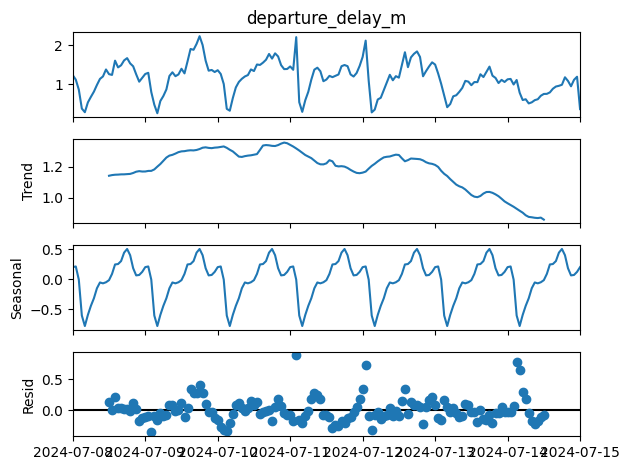

In [6]:
decomposition = seasonal_decompose(tsa['departure_delay_m'], model='additive', period=24)
decomposition.plot()
plt.show()

In [7]:
tsa["departure_delay_m"] = scaler.fit_transform(tsa[["departure_delay_m"]])
tsa.head()

,departure_delay_m,departure_plan_hour
departure_plan_datetime,,
2024-07-08 00:00:00,0.494009,0.0
2024-07-08 01:00:00,0.435369,1.0
2024-07-08 02:00:00,0.306128,2.0
2024-07-08 03:00:00,0.060443,3.0
2024-07-08 04:00:00,0.013086,4.0


In [8]:
from scipy.stats import zscore

statelist = df.state.unique()
frames = {}
for state in statelist:
    frames[state] = df[df["state"] == state]
    frames[state] = frames[state][["departure_plan_datetime","departure_delay_m","departure_plan_hour"]].groupby("departure_plan_datetime", as_index=False).mean()
    frames[state]['zscore'] = zscore(frames[state]['departure_delay_m'])
    # Identify outliers with Z-score threshold of 3
    outliers = frames[state][np.abs(frames[state]['zscore']) > 3]
    # Replace outliers with the median of the surrounding values
    for index in outliers.index:
        frames[state].at[index, 'departure_delay_m'] = frames[state]['departure_delay_m'].median()#only flattening the most excessive spikes for some states
    # Drop the zscore column as it's no longer needed
    frames[state] = frames[state].drop(columns=['zscore'])
    frames[state]['departure_delay_m'] = frames[state]['departure_delay_m'].rolling(window=3).mean()
    frames[state] = frames[state].set_index('departure_plan_datetime').asfreq('h', fill_value=frames[state].departure_delay_m.mean())
    frames[state]["departure_delay_m"] = scaler.fit_transform(frames[state][["departure_delay_m"]])


In [9]:
result = adfuller(tsa['departure_delay_m'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])
if result[1] < 0.05:
    print("Series is stationary. No differencing needed.")

ADF Statistic: -4.709630542141706
p-value: 8.071627457319952e-05
Critical Values: {'1%': -3.470126426071447, '5%': -2.8790075987120027, '10%': -2.5760826967621644}
Series is stationary. No differencing needed.


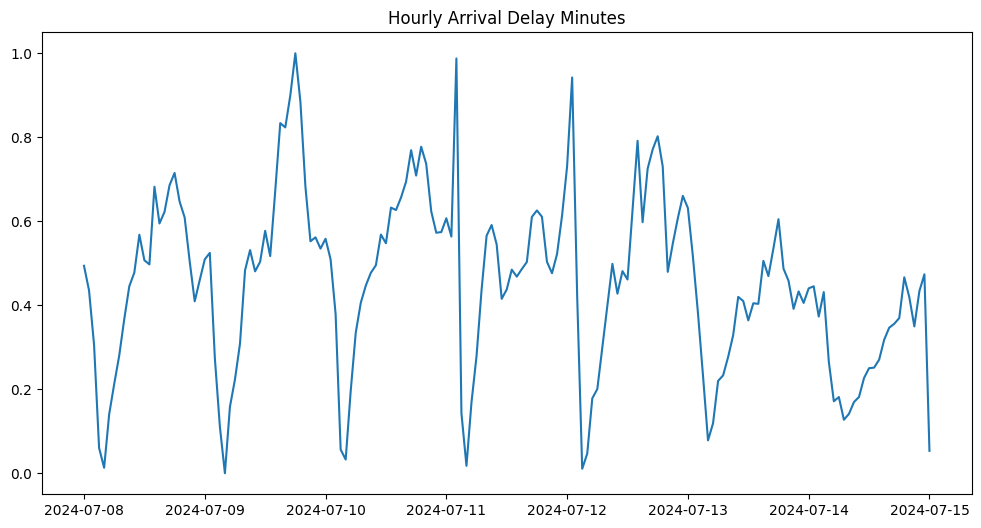

In [10]:
# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(tsa['departure_delay_m'])
plt.title('Hourly Arrival Delay Minutes')
plt.show()

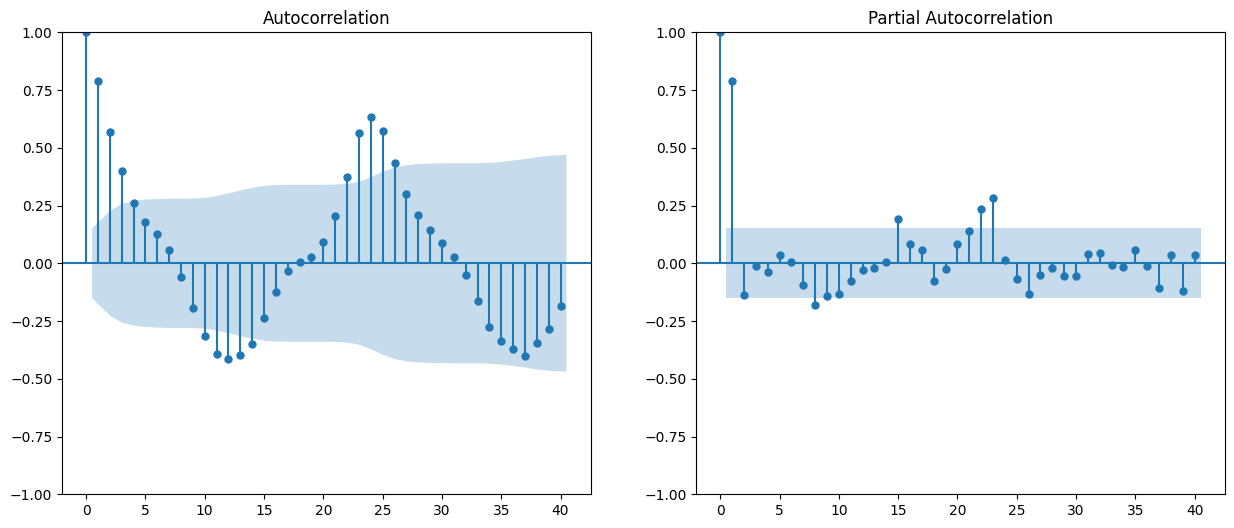

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF and PACF plots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
plot_acf(tsa['departure_delay_m'], lags=40, ax=axes[0])
plot_pacf(tsa['departure_delay_m'], lags=40, ax=axes[1])
plt.show()

Autocorrelation and partial autocrrelaction suggets to use between 1-3 for p and q parameters

In [12]:
from warnings import filterwarnings
filterwarnings('ignore')

In [28]:
trainpart = 0.85

In [29]:
i_split = int(trainpart * len(tsa))
tsa_train, tsa_test = tsa.iloc[:i_split,:], tsa.iloc[i_split:,:]
print('all forecasts must be {} periods long.'.format(len(tsa_test)))

all forecasts must be 26 periods long.


In [15]:
import itertools
import math
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the range of values for p, d, q, P, D, Q, and m
p_values = range(1, 4)  # Autoregressive order
d_values = [0]          # Differencing order
q_values = range(1, 4)  # Moving average order
P_values = range(1, 4)  # Seasonal autoregressive order
D_values = range(0, 1)  # Seasonal differencing order
Q_values = range(1, 4)  # Seasonal moving average order
m_values = [24]         # Seasonal period

# Create all possible combinations of SARIMA parameters
param_combinations = list(itertools.product(p_values, 
                                            d_values, 
                                            q_values, 
                                            P_values, 
                                            D_values, 
                                            Q_values, 
                                            m_values))

# Initialize AIC with a large value
best_aic = float("inf")  
best_params = None

In [16]:
# Perform grid search
for params in param_combinations:
    order = params[:3]
    seasonal_order = params[3:]
    
    try:
        model = SARIMAX(tsa_train["departure_delay_m"], 
                               order=order, 
                               seasonal_order=seasonal_order)
        result = model.fit(disp=False, maxiter=100)
        aic = result.aic
        
        # Ensure the convergence of the model
        if not math.isinf(result.zvalues.mean()):
            print(order, seasonal_order, aic)
        
            if aic < best_aic:
                best_aic = aic
                best_params = params
                
        else:
            print(order, seasonal_order, 'not converged')

    except:
        continue

# Print the best parameters and AIC
print("Best Parameters:", best_params)
print("Best AIC:", best_aic)

(1, 0, 1) (1, 0, 1, 24) -146.08671804865332
(1, 0, 1) (1, 0, 2, 24) -144.15666417269452
(1, 0, 1) (1, 0, 3, 24) -142.36716760405568
(1, 0, 1) (2, 0, 1, 24) -144.12611497961234
(1, 0, 1) (2, 0, 2, 24) -141.92653412029398
(1, 0, 1) (2, 0, 3, 24) -140.14816849251196
(1, 0, 1) (3, 0, 1, 24) -142.33317100428434
(1, 0, 1) (3, 0, 2, 24) -140.15236752508005
(1, 0, 1) (3, 0, 3, 24) -138.1109960010744
(1, 0, 2) (1, 0, 1, 24) -146.1809009042313
(1, 0, 2) (1, 0, 2, 24) -144.21353167060258
(1, 0, 2) (1, 0, 3, 24) -142.4091109196122
(1, 0, 2) (2, 0, 1, 24) -144.1862692818716
(1, 0, 2) (2, 0, 2, 24) -142.2235004808366
(1, 0, 2) (2, 0, 3, 24) -140.2656129340076
(1, 0, 2) (3, 0, 1, 24) -142.81929149771878
(1, 0, 2) (3, 0, 2, 24) -140.28148694929575
(1, 0, 2) (3, 0, 3, 24) -138.0721682528465
(1, 0, 3) (1, 0, 1, 24) -144.30033836764886
(1, 0, 3) (1, 0, 2, 24) -142.35948551076868
(1, 0, 3) (1, 0, 3, 24) -140.54865200713155
(1, 0, 3) (2, 0, 1, 24) -142.28926270266763
(1, 0, 3) (2, 0, 2, 24) -139.8298250244

In [30]:
# refit the SARIMA model
model = SARIMAX(tsa_train['departure_delay_m'], 
                order=best_params[:3], 
                seasonal_order=best_params[3:], 
                )
model_fit = model.fit(maxiter=200)



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.50125D-01    |proj g|=  1.31781D+00

At iterate    5    f= -5.00950D-01    |proj g|=  2.36210D+00

At iterate   10    f= -6.12932D-01    |proj g|=  3.84198D-01


 This problem is unconstrained.



At iterate   15    f= -6.87830D-01    |proj g|=  1.34092D-01

At iterate   20    f= -6.93895D-01    |proj g|=  4.02762D-02

At iterate   25    f= -7.13071D-01    |proj g|=  8.58375D-02

At iterate   30    f= -7.17112D-01    |proj g|=  8.63408D-02

At iterate   35    f= -7.18993D-01    |proj g|=  2.88594D-02

At iterate   40    f= -7.19156D-01    |proj g|=  2.71739D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     41     65      1     0     0   2.717D-02  -7.192D-01
  F = -0.71915571409684576     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


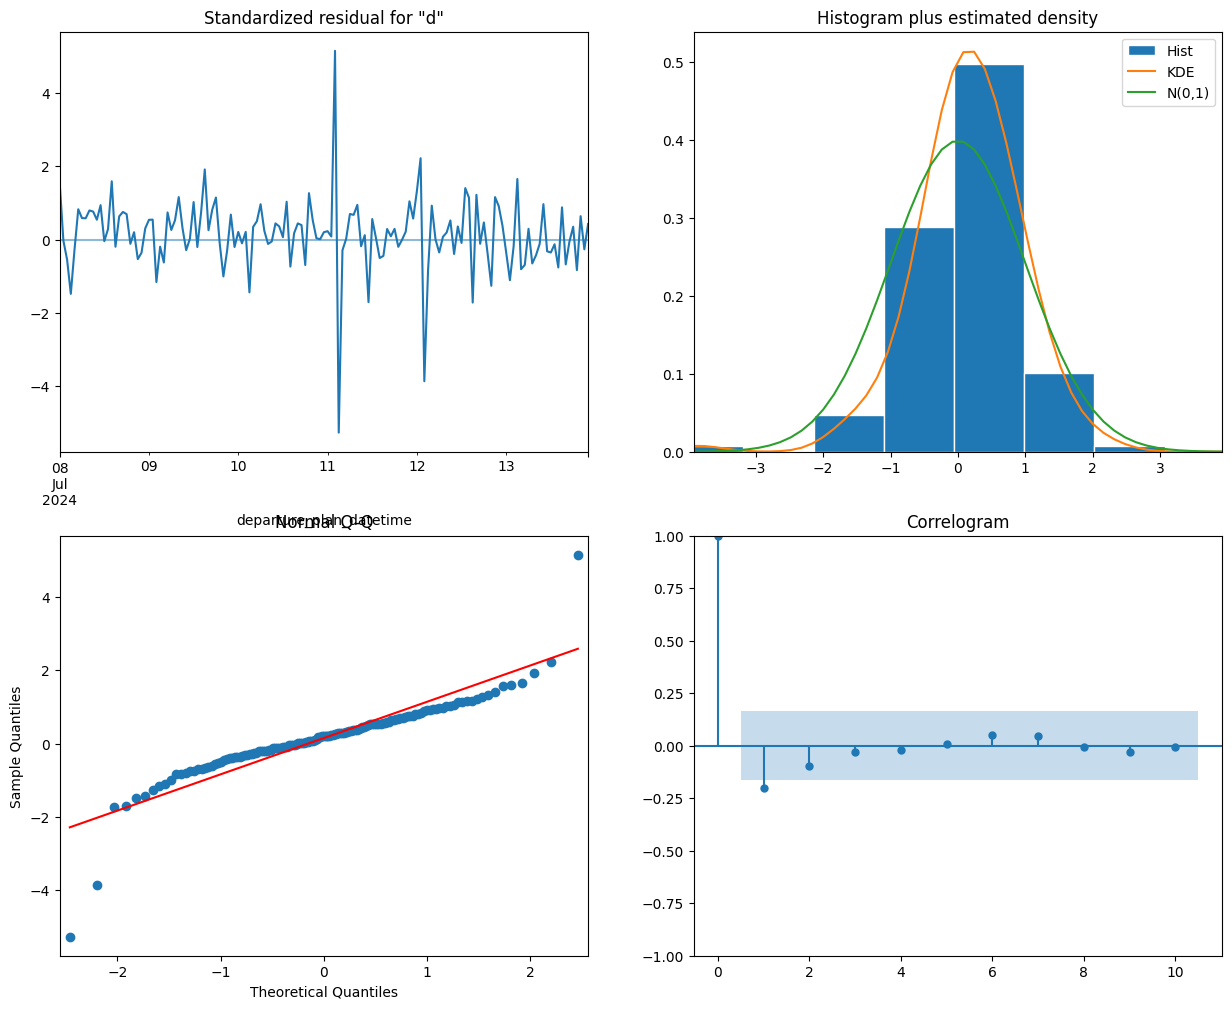

In [31]:
# Diagnostic plots
model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

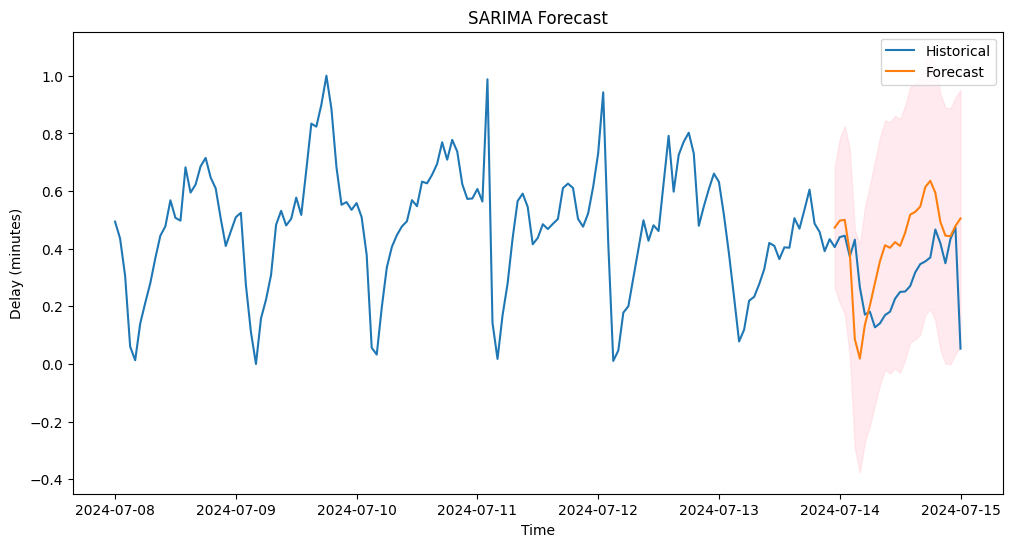

In [32]:
forecast_steps = len(tsa_test)
forecast = model_fit.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=tsa_test.index[0], periods=forecast_steps, freq='h')[0:]
forecast_series = pd.Series(forecast.predicted_mean, index=forecast_index)
confidence_intervals = forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(tsa['departure_delay_m'], label='Historical')
plt.plot(forecast_series, label='Forecast')
plt.fill_between(forecast_index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
plt.title('SARIMA Forecast')
plt.xlabel('Time')
plt.ylabel('Delay (minutes)')
plt.legend()
plt.show()

In [33]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(tsa_test["departure_delay_m"], forecast_series))
print(f'RMSE: {rmse}')
print(f"predictability: {tsa['departure_delay_m'].std()/rmse}")


RMSE: 0.1955078533343949
predictability: 1.0721622551861345


# Searching for Systematic Issues

In [34]:
from warnings import filterwarnings
filterwarnings('ignore')

In [53]:
frames_train = {}
frames_test = {}
frames_forecast_l = {}
for state, data in frames.items():
    i_split = int(5/7 * len(data))
    frames_train[state], frames_test[state] = frames[state].iloc[:i_split,:], frames[state].iloc[i_split:,:]
    frames_forecast_l[state] = len(frames_test[state])

In [55]:
models = {}
for state, data in frames_train.items():
    model = SARIMAX(data['departure_delay_m'], 
                    order=best_params[:3], 
                    seasonal_order=(3,0,2,24), 
                    )
    fit = model.fit(disp=False, maxiter=200)
    models[state] = fit
    print(f"fitted to {state}")

    if math.isinf(fit.zvalues.mean()):
        print(f'{state}not converged')

fitted to Nordrhein-Westfalen
fitted to Baden-Württemberg
fitted to Niedersachsen
fitted to Schleswig-Holstein
fitted to Bayern
fitted to Berlin
fitted to Hamburg
fitted to Thüringen
fitted to Rheinland-Pfalz
fitted to Mecklenburg-Vorpommern
fitted to Sachsen
fitted to Sachsen-Anhalt
fitted to Brandenburg
fitted to Hessen
fitted to Saarland
fitted to Bremen


calc for Nordrhein-Westfalen


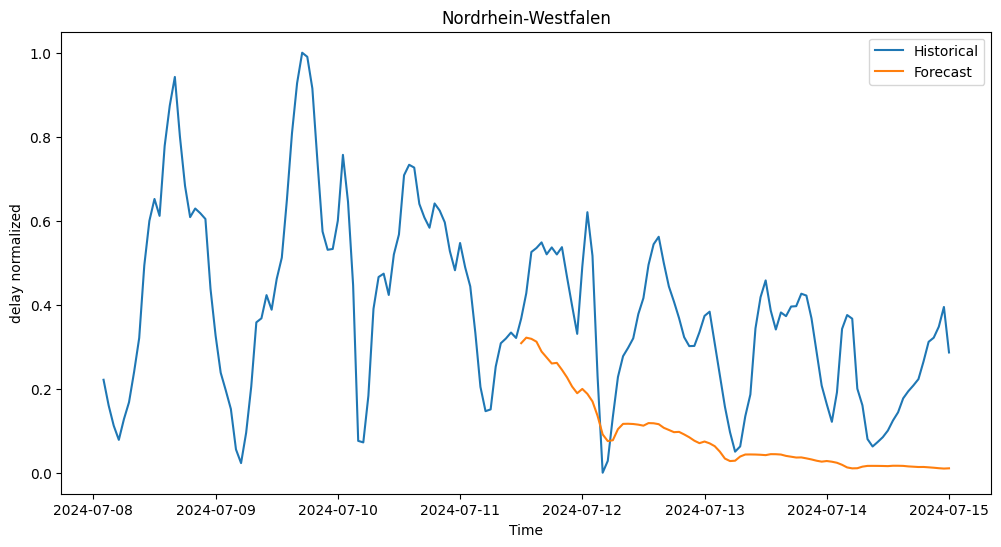

calc for Baden-Württemberg


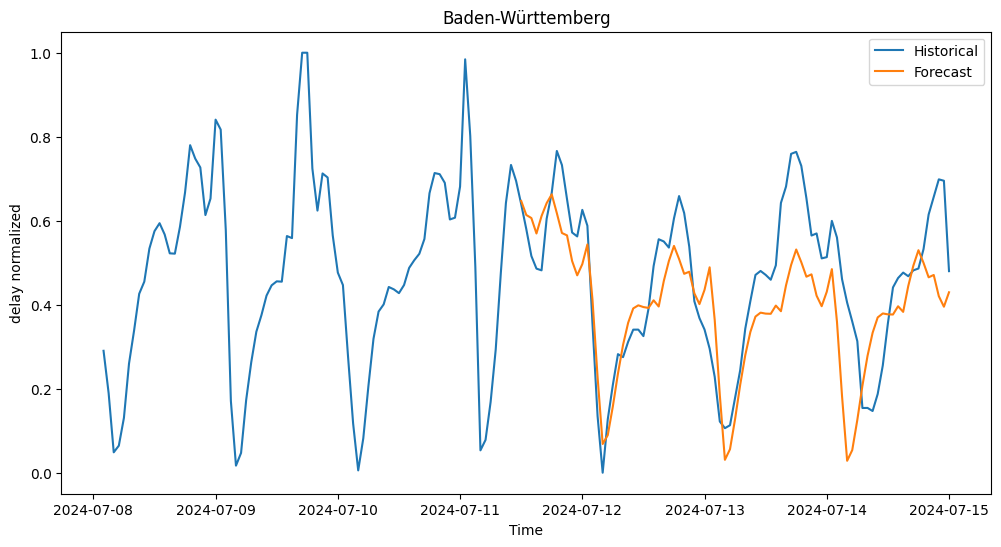

calc for Niedersachsen


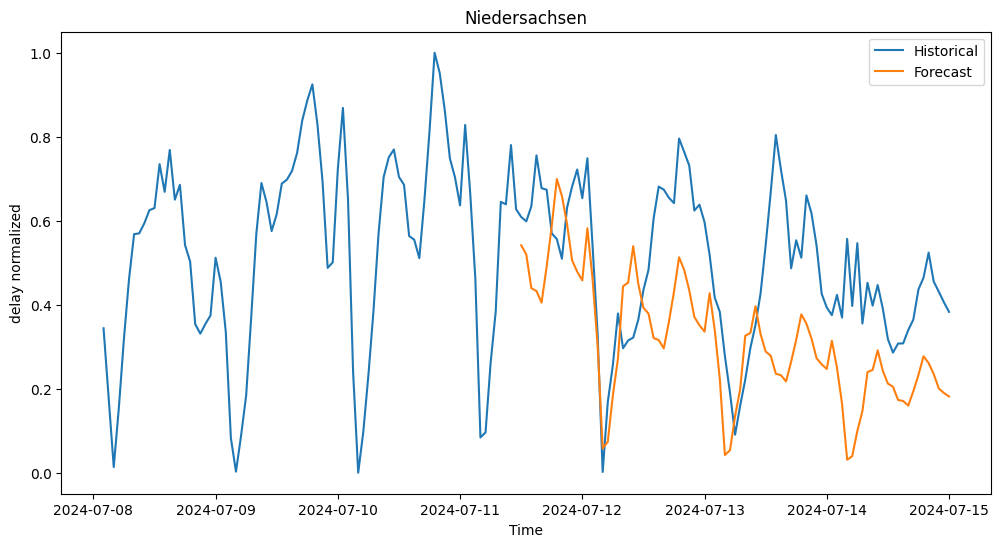

calc for Schleswig-Holstein


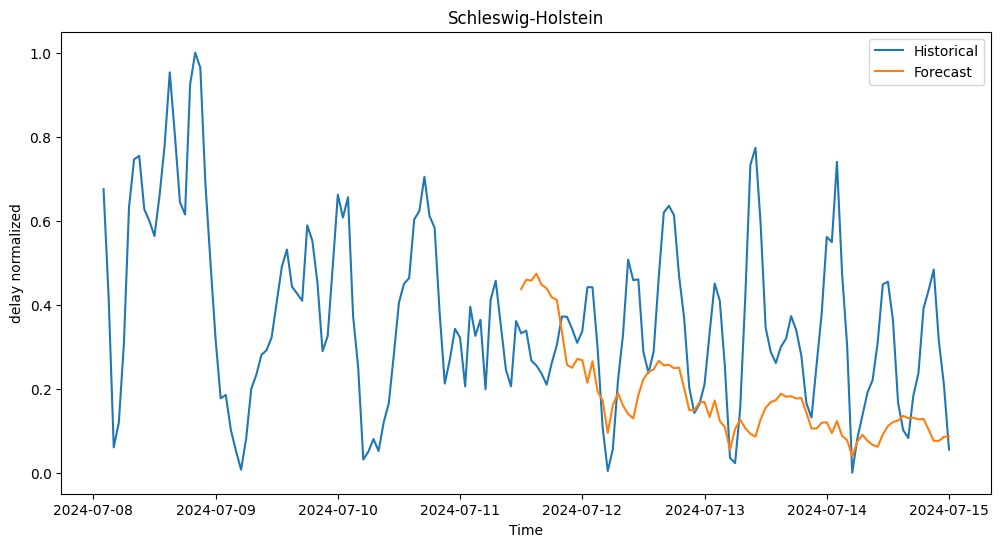

calc for Bayern


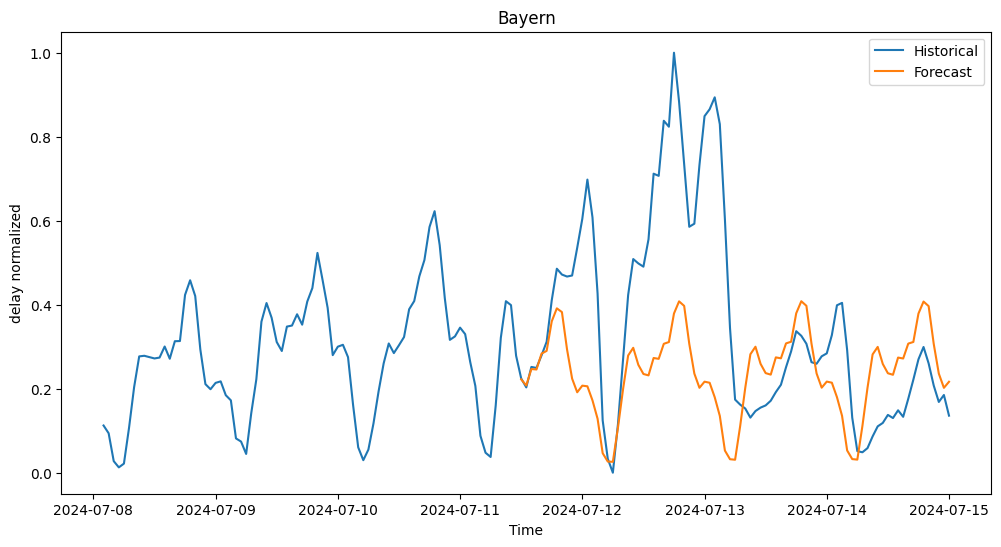

calc for Berlin


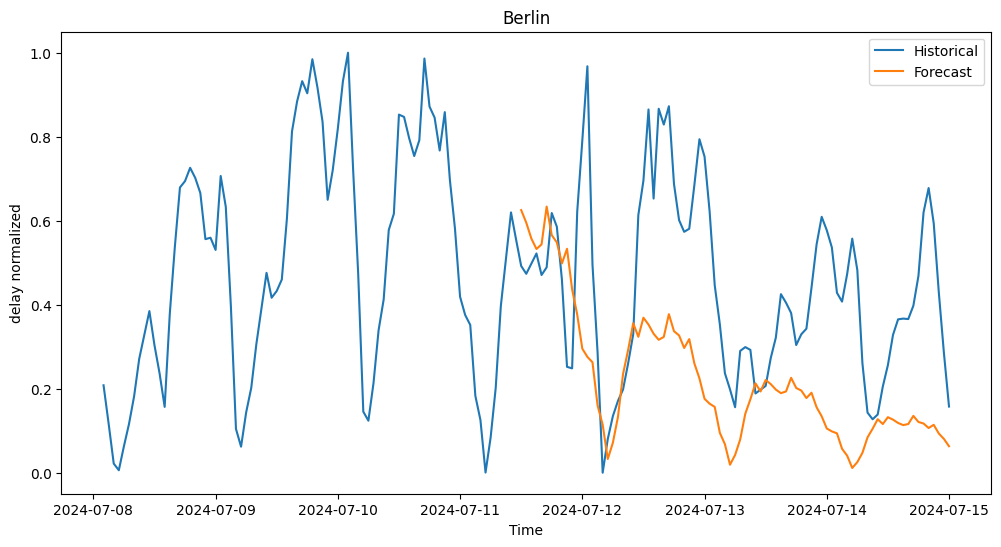

calc for Hamburg


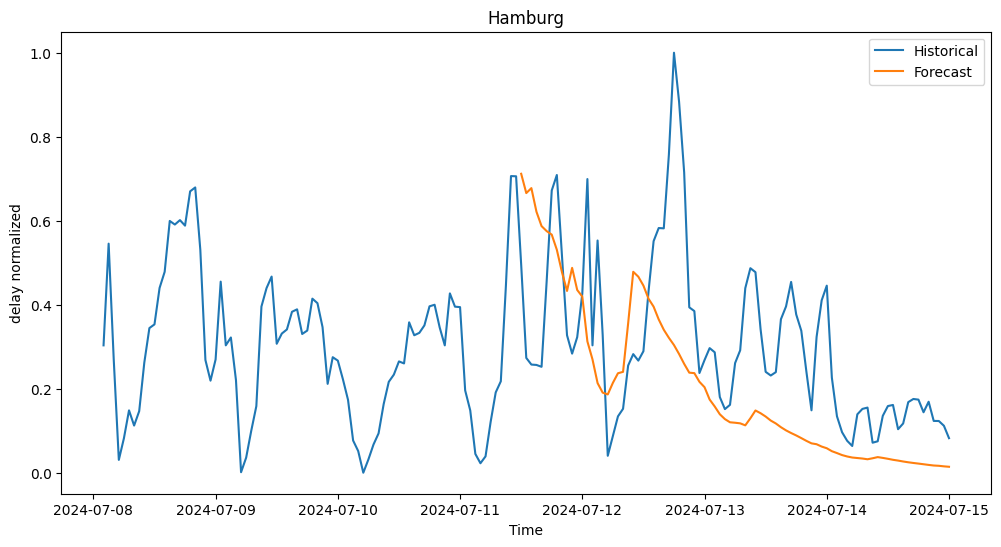

calc for Thüringen


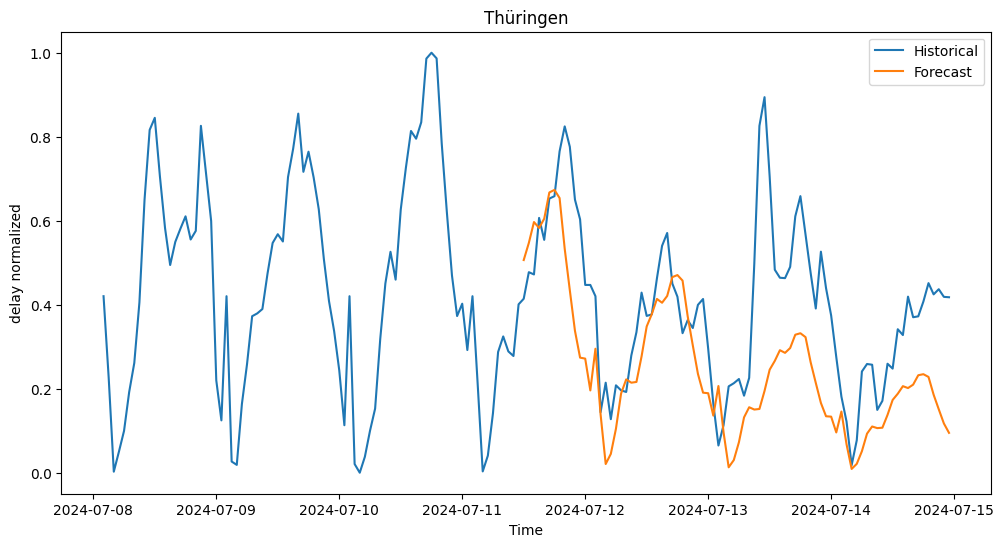

calc for Rheinland-Pfalz


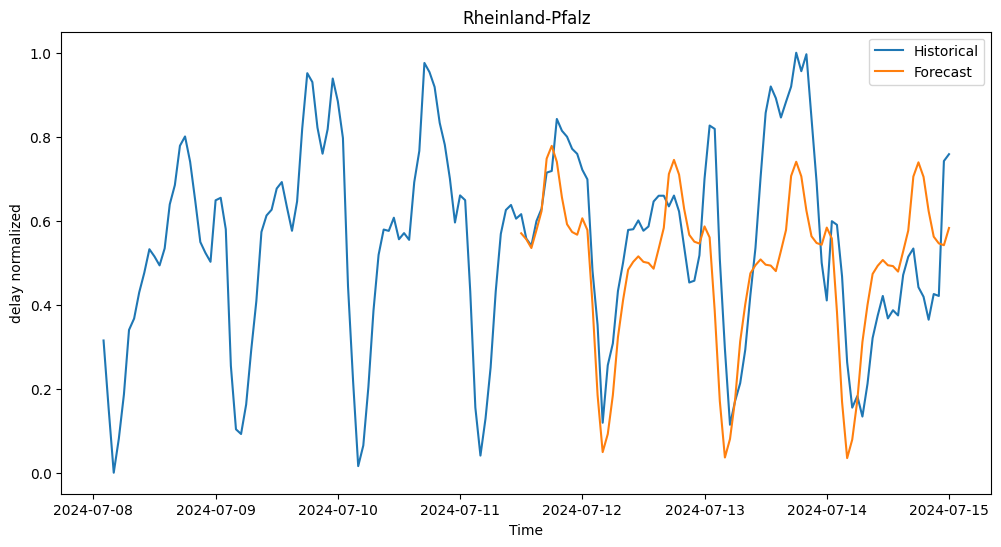

calc for Mecklenburg-Vorpommern


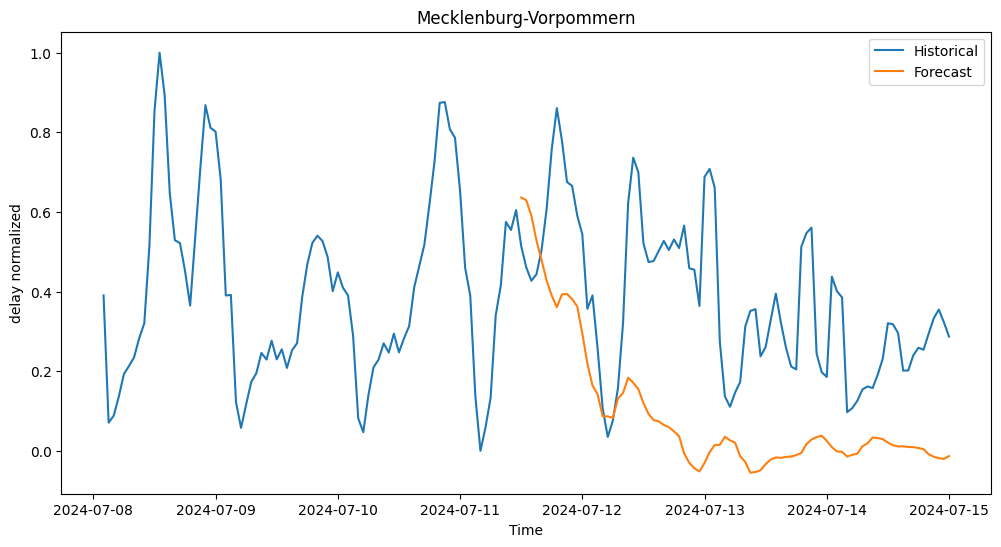

calc for Sachsen


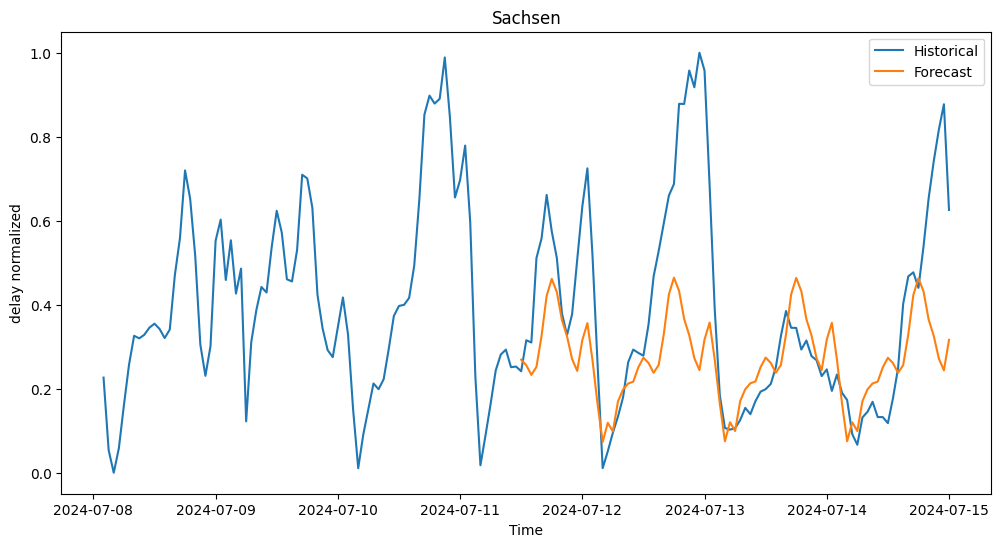

calc for Sachsen-Anhalt


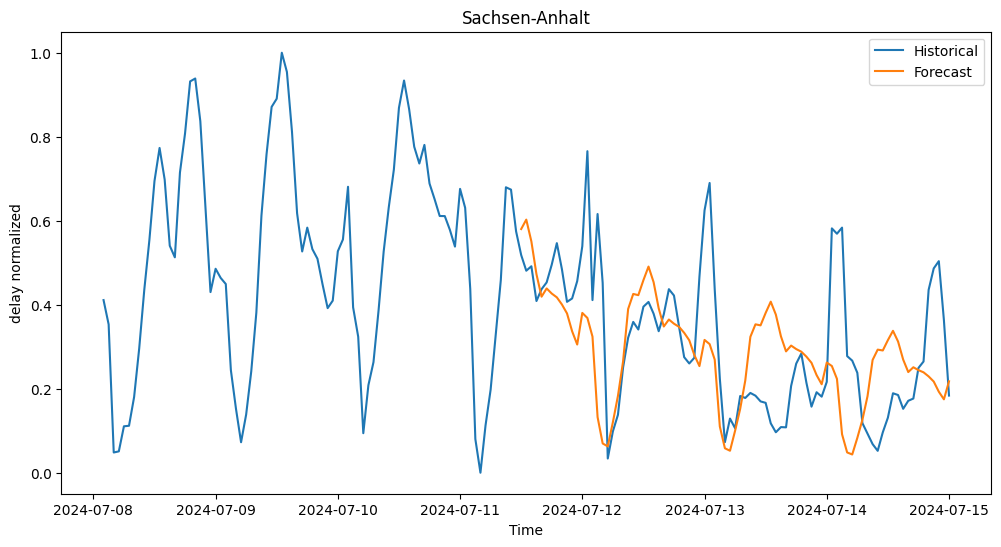

calc for Brandenburg


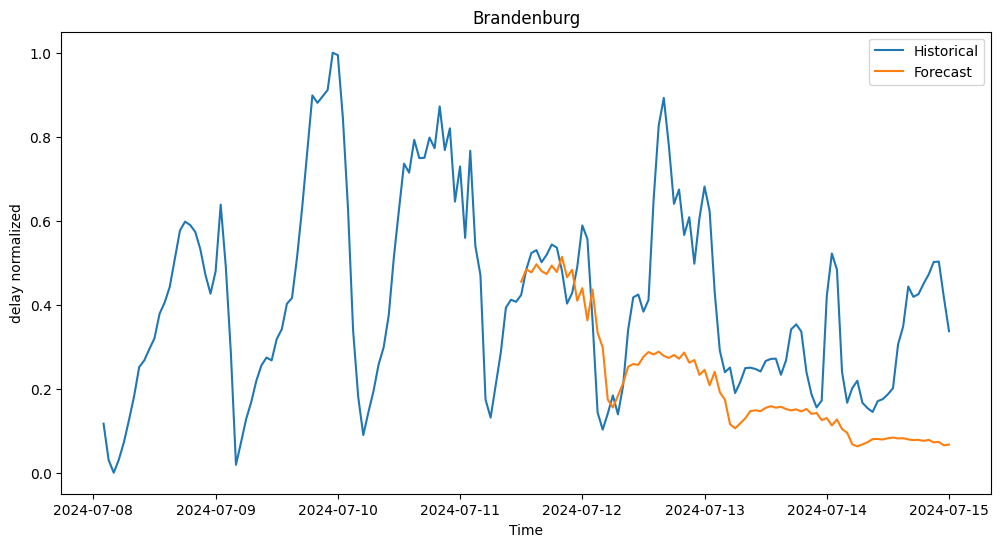

calc for Hessen


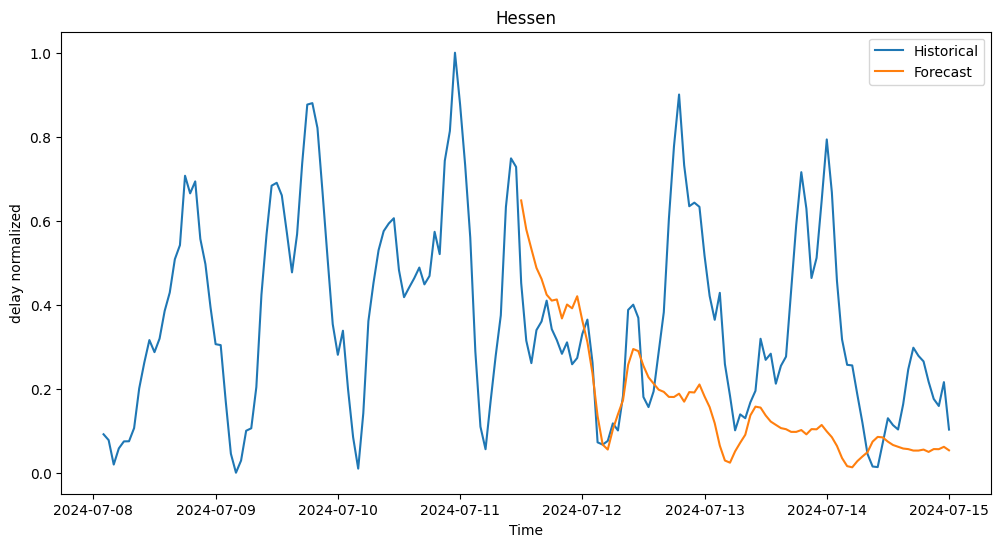

calc for Saarland


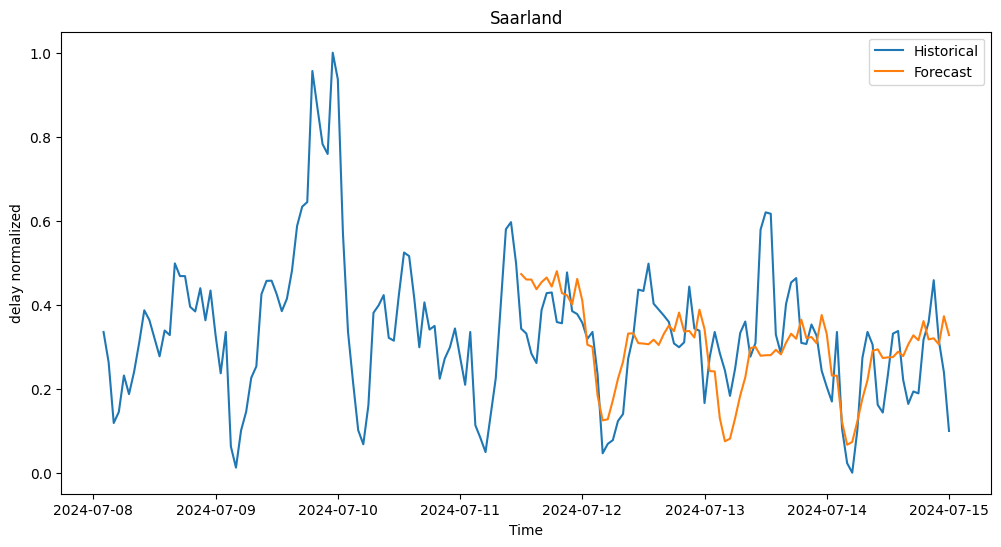

calc for Bremen


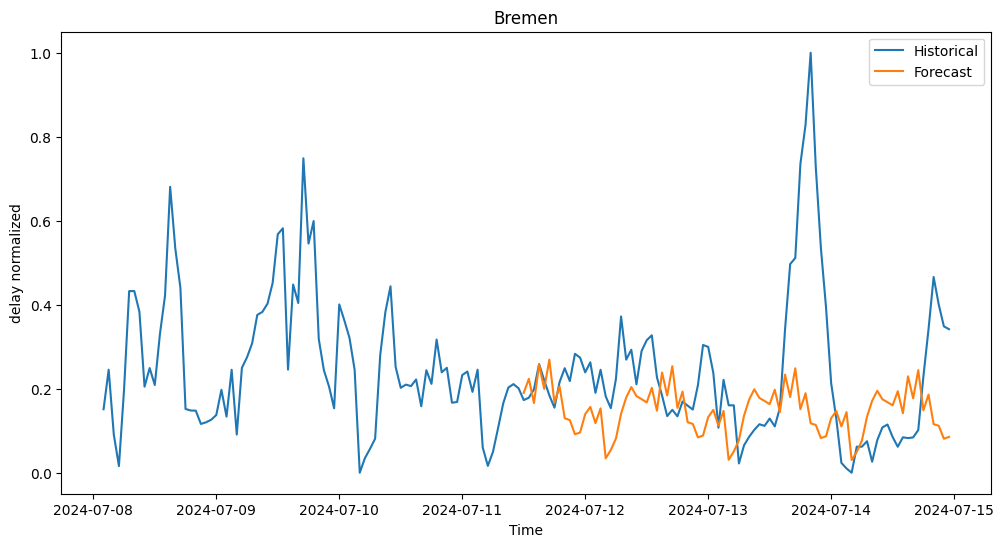

In [50]:
forecasts = {}
comparison = pd.DataFrame(columns=["rmse", "std"])

for state, data in frames_test.items():
    try:
        forecast_steps = frames_forecast_l[state]
        forecast = models[state].get_forecast(steps=forecast_steps)
        forecast_index = pd.date_range(start=data.index[0], periods=forecast_steps, freq='h')
        forecast_series = pd.Series(forecast.predicted_mean, index=forecast_index)
        #confidence_intervals = forecast.conf_int()
        print(f"calc for {state}")
        rmse = np.sqrt(mean_squared_error(data["departure_delay_m"], forecast_series))
        comparison.loc[state, "rmse"] = rmse
        comparison.loc[state, "std"] = frames_test[state].departure_delay_m.std()



        # Plot the forecast
        plt.figure(figsize=(12, 6))
        plt.plot(frames[state]['departure_delay_m'], label='Historical')
        plt.plot(forecast_series, label='Forecast')
        #plt.fill_between(forecast_index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
        plt.title(state)
        plt.xlabel('Time')
        plt.ylabel('delay normalized')
        plt.legend()
        plt.show()
    except:
        print(f"{state} is unpredictable")
        comparison.loc[state, "rmse"] = 1
        continue






In [51]:
comparison["predictability"] = comparison["std"] / comparison["rmse"]

In [52]:
comparison.sort_values("predictability", ascending=False)

,rmse,std,predictability
Baden-Württemberg,0.133848,0.182936,1.366744
Rheinland-Pfalz,0.181037,0.221398,1.222941
Saarland,0.113316,0.124285,1.096799
Sachsen,0.232336,0.249879,1.075506
Sachsen-Anhalt,0.172548,0.169218,0.980699
Bayern,0.269354,0.245552,0.911632
Thüringen,0.20854,0.188143,0.902195
Hamburg,0.222718,0.197739,0.887842
Bremen,0.201931,0.178284,0.882896
Brandenburg,0.230864,0.177334,0.768132
